<a href="https://colab.research.google.com/github/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/blob/master/Example_on_BRATS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note
- [Colab Only] Means the associated cell is required only if you are running the model on Google Colaboratory

## Mount Drive [Colab Only]
Mount the google drive to access the dataset stored on drive.

## Extract the Dataset

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


gpu_config = ConfigProto()
gpu_config.gpu_options.allow_growth = True
session = InteractiveSession(config=gpu_config)

/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type

## Get required packages
- **SimpleITK**: For loading the dataset
- **[model.py](https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/)**: The model from BRATS2018 winning paper

## Imports and helper functions

In [2]:
import SimpleITK as sitk  # For loading the dataset
import numpy as np  # For data manipulation
from model import build_model  # For creating the model
import glob  # For populating the list of files
from scipy.ndimage import zoom  # For resizing
import re  # For parsing the filenames (to know their modality)
import cv2

Using TensorFlow backend.


In [3]:
def read_img(img_path):
    """
    Reads a .nii.gz image and returns as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path))

In [4]:
def post_process_label(img):
    kernel = np.ones((3, 3))
    imgo = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    kernel = np.ones((3, 3))
    imgo = cv2.dilate(imgo, kernel, iterations=1)
    return imgo

def resize(img, shape, mode='constant', orig_shape=(155, 240, 240)):
    """
    Wrapper for scipy.ndimage.zoom suited for MRI images.
    """
    assert len(shape) == 3, "Can not have more than 3 dimensions"
    factors = (
        shape[0]/orig_shape[0],
        shape[1]/orig_shape[1], 
        shape[2]/orig_shape[2]
    )
    
    # Resize to the given shape
    return zoom(img, factors, mode=mode)


def preprocess(img, out_shape=None):
    """
    Preprocess the image.
    Just an example, you can add more preprocessing steps if you wish to.
    """
    if out_shape is not None:
        img = resize(img, out_shape, mode='constant')
    
    # Normalize the image
    mean = img.mean()
    std = img.std()
    return (img - mean) / std


def preprocess_label(img, out_shape=None, mode='nearest'):
    """
    Separates out the 3 labels from the segmentation provided, namely:
    GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2))
    and the necrotic and non-enhancing tumor core (NCR/NET — label 1)
    """
    #ncr = img == 1  # Necrotic and Non-Enhancing Tumor (NCR/NET)
    ed = img == 2  # Peritumoral Edema (ED)
    et = img == 4  # GD-enhancing Tumor (ET)
    
    if out_shape is not None:
        #ncr = resize(ncr, out_shape, mode=mode)
        ed = resize(ed, out_shape, mode=mode)
        et = resize(et, out_shape, mode=mode)

    return np.array([ed, et], dtype=np.uint8)
    

## Loading Data


In [5]:
# Get a list of files for all modalities individually
t1 = glob.glob('/storage/brats-dataset/train/2019/MICCAI_BraTS_2019_Data_Training/HGG/*/*t1.nii.gz')
t2 = glob.glob('/storage/brats-dataset/train/2019/MICCAI_BraTS_2019_Data_Training/HGG/*/*t2.nii.gz')
flair = glob.glob('/storage/brats-dataset/train/2019/MICCAI_BraTS_2019_Data_Training/HGG/*/*flair.nii.gz')
t1ce = glob.glob('/storage/brats-dataset/train/2019/MICCAI_BraTS_2019_Data_Training/HGG/*/*t1ce.nii.gz')
seg = glob.glob('/storage/brats-dataset/train/2019/MICCAI_BraTS_2019_Data_Training/HGG/*/*seg.nii.gz')  # Ground Truth

Parse all the filenames and create a dictionary for each patient with structure:

{<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t1': _<path to t1 MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t2': _<path to t2 MRI&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'flair': _<path to FLAIR MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t1ce': _<path to t1ce MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'seg': _<path to Ground Truth file&gt;_,<br />
}<br />

In [6]:
pat = re.compile('.*_(\w*)\.nii\.gz')

data_paths = [{
    pat.findall(item)[0]:item
    for item in items
}
for items in list(zip(t1, t2, t1ce, flair, seg))]

## Load the data in a Numpy array
Creating an empty Numpy array beforehand and then filling up the data helps you gauge beforehand if the data fits in your memory.



_Loading only the first 4 images here, to save time._

In [7]:
input_shape = (4, 80, 96, 64)
output_channels = 2
data = np.empty((len(data_paths[:]),) + input_shape, dtype=np.float32)
labels = np.empty((len(data_paths[:]), output_channels) + input_shape[1:], dtype=np.uint8)

In [8]:
import math

# Parameters for the progress bar
total = len(data_paths[:4])
step = 25 / total

for i, imgs in enumerate(data_paths[:4]):
    try:
        data[i] = np.array([preprocess(read_img(imgs[m]), input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
        labels[i] = preprocess_label(read_img(imgs['seg']), input_shape[1:])[None, ...]
        
        # Print the progress bar
        print('\r' + f'Progress: '
            f"[{'=' * int((i+1) * step) + ' ' * (24 - int((i+1) * step))}]"
            f"({math.ceil((i+1) * 100 / (total))} %)",
            end='')
    except Exception as e:
        print(f'Something went wrong with {imgs["t1"]}, skipping...\n Exception:\n{str(e)}')
        continue

Progress: [=========================](100 %)

In [9]:
labels.shape

(4, 2, 80, 96, 64)

## Model

build the model

In [10]:
model = build_model(input_shape=input_shape, output_channels=2)

Train the model

In [11]:
history=model.fit(data, labels, batch_size=1, epochs=70*10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/700
4/4 [==============================] - 9s 2s/step - loss: 1.3053 - dice_coefficient: 0.0060
Epoch 2/700
4/4 [==============================] - 3s 737ms/step - loss: 1.2941 - dice_coefficient: 0.0067
Epoch 3/700
4/4 [==============================] - 3s 734ms/step - loss: 1.2648 - dice_coefficient: 0.0320
Epoch 4/700
4/4 [==============================] - 3s 749ms/step - loss: 1.2688 - dice_coefficient: 0.0262
Epoch 5/700
4/4 [==============================] - 3s 769ms/step - loss: 1.3019 - dice_coefficient: 0.0000e+00
Epoch 6/700
4/4 [==============================] - 3s 766ms/step - loss: 1.2974 - dice_coefficient: 0.0000e+00
Epoch 7/700
4/4 [==============================] - 3s 699ms/step - loss: 1.2983 - dice_coefficient: 0.0000e+00
Epoch 8/700
4/4 [==============================] - 3s 698ms/step - loss: 1.2901 - dice_coefficient: 0.0000e+00
Epoch 9/700
4/4 [===================

In [12]:
model.save('vaemodel.h5')
model.save_weights('vaemodel__weights.h5')


That's it!

## Closing Regards

If you are resizing the segmentation mask, the resized segmentation mask retains the overall shape, but loses a lot of pixels and becomes somewhat 'grainy'. See the illustration below.

1. Original segmentation mask:

(240, 240)
[0 1]
612


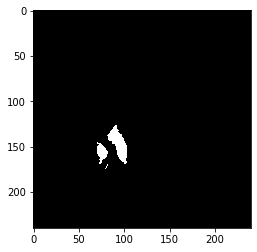

In [13]:
import matplotlib.pyplot as plt
img = (read_img(seg[0])[100] == 2).astype(np.uint8)
print(img.shape)
print(np.unique(img))
print(img.sum())
plt.imshow(img, cmap='Greys_r')

After resizing to (80, 96, 64)

(96, 64)
[0]
0


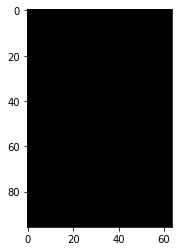

In [14]:
img = preprocess_label(read_img(seg[0]), out_shape=(80, 96, 64), mode='nearest')[1][50]
print(img.shape)
print(np.unique(img))
print(img.sum())
plt.imshow(img, cmap='Greys_r')

One can clearly notice that there are now a lot of black pixels in the region where there should have been only white pixels. This can potentially hurt our model. So, it is best to not resize the image too much. But, due to computational constraints and the model requirements, it is unavoidable. 

However, given below are a few things one could try to reduce the downsampling noise as much as possible.

In [15]:
import cv2

- Original Image > preprocess_label > Morphological Closing

[0]
0


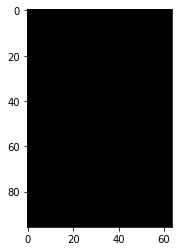

In [16]:
kernel = np.ones((3, 3))
img_closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
print(np.unique(img_closed))
print(img_closed.sum())
plt.imshow(img_closed, cmap='Greys_r')

- Original Image > preprocess_label > Morphological Dilation

[0]
0


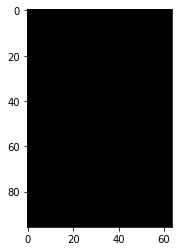

In [17]:
kernel = np.ones((3, 3))
img_dilated = cv2.dilate(img, kernel, iterations=1)
print(np.unique(img_dilated))
print(img_dilated.sum())
plt.imshow(img_dilated, cmap='Greys_r')

In [21]:
import json
with open('history.json', 'w') as file:

    json.dump(str(history.history), file)

In [22]:
import matplotlib.pyplot as plt 

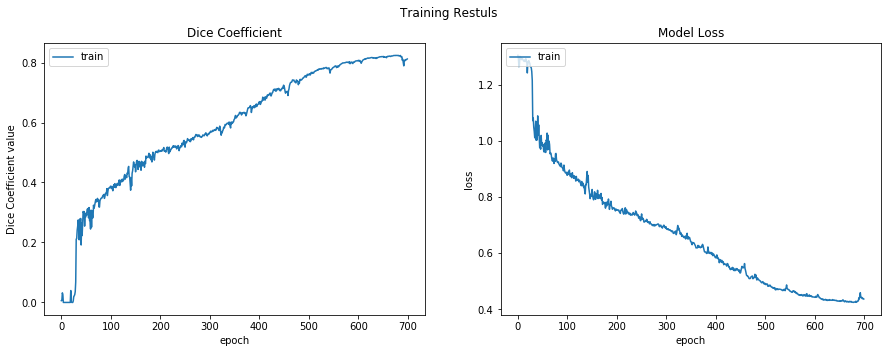

In [26]:
trainig_history=history
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.suptitle('Training Restuls')
#plt.figure(figsize=(30,20))
# summarize history for accuracy
ax1.plot(history.epoch,history.history['dice_coefficient'])
ax1.set_title('Dice Coefficient')
ax1.set_ylabel('Dice Coefficient value')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
#plt.show()
# summarize history for loss
ax2.plot(history.epoch,history.history['loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

You could try these things to get even better results.

## Feedback